# DC GAN

Deconvolution GAN

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt 
%matplotlib inline
print(tf.__version__)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import BatchNormalization, Reshape, UpSampling2D, MaxPool2D, Flatten
import numpy as np 

import tqdm

2.0.0-alpha0


#  Define Generator

In [2]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()        
        self.dense1 = Dense(1024, activation='tanh', input_dim=(100))
        self.dense2 = Dense(128*7*7, activation='tanh')
        self.bn1 = BatchNormalization()
        self.reshape1 = Reshape((7,7,128),input_shape=(128*7*7,))
        self.up1 = UpSampling2D(size=(2,2))
        self.conv1 = Conv2D(64,(5,5), padding='same', activation='tanh')
        self.up2 = UpSampling2D(size=(2,2))
        self.conv2 = Conv2D(1,(5,5), padding='same', activation='tanh')
        
    def __call__(self, x):
        x = self.dense1(x)        
        x = self.dense2(x)                
        x = self.bn1(x)        
        x = self.reshape1(x)        
        x = self.up1(x)        
        x = self.conv1(x)        
        x = self.up2(x)        
        x = self.conv2(x)        
        return x 

In [3]:
test = tf.random.normal((1,100))
print(test.shape)
g = Generator()
result = g(test[0:])
print(result.shape)

(1, 100)
(1, 28, 28, 1)


# Define Discrimator

In [4]:
class Discrimator(Model):
    def __init__(self):
        super(Discrimator,self).__init__()
        self.conv1 = Conv2D(64, (5,5), padding='same', activation='tanh')
        self.maxPool1 = MaxPool2D(pool_size=(2,2))
        self.conv2 = Conv2D(128, (5,5), padding='same', activation='tanh')
        self.maxPool2 = MaxPool2D(pool_size=(2,2))
        self.flatten = Flatten()
        self.dense1 = Dense(1024, activation='tanh')
        self.dense2 = Dense(1, activation='sigmoid')
        
    def __call__(self, x):
        x = self.conv1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.maxPool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x 

In [5]:
test = tf.random.normal((1,28,28,1))
print(test.shape)
d = Discrimator()
result = d(test)
print(result.shape)

(1, 28, 28, 1)
(1, 1)


# Define Z (1024)

In [6]:
BATCH_SIZE=32
LATENT_SIZE=100
z = tf.random.uniform(minval=-1,maxval=1,shape=(BATCH_SIZE, LATENT_SIZE), seed=0)

In [7]:
print(z.shape)

(32, 100)


In [8]:
buffer_size =10000 
batch_size =1000

In [9]:
(train_imgs, train_labels), (_,_)  = tf.keras.datasets.mnist.load_data()
train_imgs = train_imgs[train_labels == 0]
print(f"train_imgs : {train_imgs.shape}")
x_train = train_imgs.astype('float32') / 255.0 
x_train = x_train.reshape((x_train.shape[0],) + (28, 28, 1)) 
print(x_train.shape) 
# Init network 

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

train_imgs : (5923, 28, 28)
(5923, 28, 28, 1)


In [10]:
def convert_array_to_image(array):
    """Converts a numpy array to a PIL Image and undoes any rescaling."""
    img = PIL.Image.fromarray(np.uint8((array + 1.0) / 2.0 * 255), mode='RGB')
    return img

def generator_loss(generated_output):
        return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), logits=generated_output)
        
def discriminator_loss(real_output, generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(
        multi_class_labels=tf.ones_like(real_output), logits=real_output)
    
    generated_loss = tf.losses.sigmoid_cross_entropy(
        multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
    
    total_loss = real_loss + generated_loss
    return total_loss

gen_opt = tf.train.AdamOptimizer(1e-4)
dis_opt = tf.train.AdamOptimizer(1e-4)    

In [11]:
from tensorflow.losses import sigmoid_cross_entropy

@tf.function
def train_step(imgs, noise):
    total_d_loss = 0.0 
    total_a_loss = 0.0 
    


    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        gen_imgs = g(noise)
        real_output = d(imgs)
        gen_output = d(gen_imgs)
        gen_loss = generator_loss(gen_output)
        dis_loss= discriminator_loss(real_output, gen_output)

    grd_gen = gen_tape.gradient(gen_loss, g.variables)
    grd_dis = dis_tape.gradient(dis_loss, d.variables)

    gen_opt.apply_gradients(zip(grd_gen, g.variables))
    dis_opt.apply_gradients(zip(grd_dis, d.variables))

In [12]:
def train_and_test(epochs):
    tf.reset_default_graph()
   
    all = 60000
    loaded_count = 0

    for epoch in range(0, epochs): 
        if (epoch+1 % 10) == 0 :
            print("Epoch:", epoch + 1) 
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100]) 
        for imgs in train_dataset:
            loaded_count = loaded_count + len(imgs)
            train_step(imgs, noise)
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100]) 
    
    fake_img = g(noise)
    fake_img = np.array(fake_img[0])
    fake_img = fake_img.reshape(fake_img.shape[0], fake_img.shape[1])
    plt.imshow(fake_img)
    plt.show()

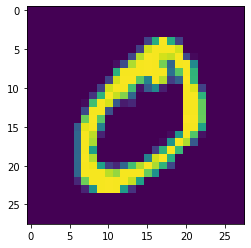

In [19]:
plt.imshow(train_imgs[0])
plt.show()

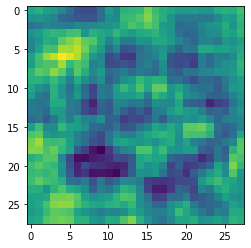

In [14]:
train_and_test(1)

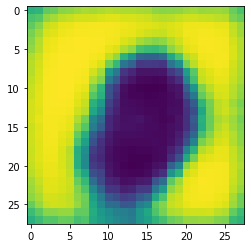

In [15]:
train_and_test(10)

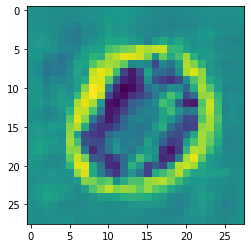

In [16]:
train_and_test(100)

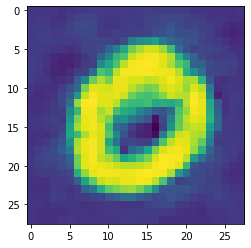

In [18]:
train_and_test(300)

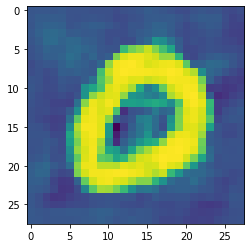

In [20]:
train_and_test(500)

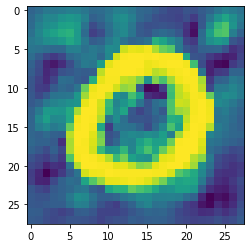

In [21]:
train_and_test(700)